# ЛР 1. Линейная регрессия

## Подготовка

Импортируем все необходимые для лабораторной библиотеки и определим функцию SMAPE.

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import make_scorer
from genetic_selection import GeneticSelectionCV
import matplotlib.pyplot as plt

import warnings  
warnings.filterwarnings('ignore')

In [10]:
def smape(f, a):
    return 100 / len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

smape_scorer = make_scorer(smape, greater_is_better=False)

Загрузим тренировочную и тестовую выборки из файла.

In [11]:
with open('7.txt', 'r') as data:
    features = int(data.readline())
    
    train_count = int(data.readline())
    train = []
    for i in range(train_count):
        train.append([int(x) for x in data.readline().split()])
    
    test_count = int(data.readline())
    test = []
    for i in range(test_count):
        test.append([int(x) for x in data.readline().split()])

train = pd.DataFrame(train)
test = pd.DataFrame(test)

Отделим признаки от классов в обеих выборках.

In [12]:
train_X, train_y = train.drop(features, axis=1), train[features]
test_X, test_y = test.drop(features, axis=1), test[features]

train_X = train_X.to_numpy()
train_y = train_y.to_numpy().reshape(-1, 1)
test_X = test_X.to_numpy()
test_y = test_y.to_numpy().reshape(-1, 1)

In [13]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_X, train_y = scaler_X.fit_transform(train_X), scaler_y.fit_transform(train_y)
test_X, test_y = scaler_X.transform(test_X), scaler_y.transform(test_y)
train_y, test_y = train_y.reshape(-1), test_y.reshape(-1)

## 1. Метод наименьших квадратов

In [14]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)

smape_train_linear = smape(linear_model.predict(train_X), train_y)
smape_test_linear = smape(linear_model.predict(test_X), test_y)

print(f'SMAPE на тренировочных данных: {smape_train_linear:5.2f}%')
print(f'SMAPE на тестовых данных:      {smape_test_linear:5.2f}%')

SMAPE на тренировочных данных:  1.77%
SMAPE на тестовых данных:       0.87%


## 2. Градиентный спуск

In [15]:
parameters = {
    'penalty': ('l1', 'l2'), 
    'alpha': np.linspace(0.000001, 0.000201, 5), 
    'learning_rate': ['adaptive'],
    'eta0': np.linspace(0.0001, 0.1001, 5)
}

sgd_model = SGDRegressor()
grid = GridSearchCV(sgd_model, parameters, scoring=smape_scorer)
grid.fit(train_X, train_y)
best_params = grid.best_params_
sgd_smape_train, sgd_smape_test = [], []
print('Лучшие параметры для SGD:       ', best_params)

max_iter_range = np.arange(20, 310, 20)
for max_iter in max_iter_range:
    best_params['max_iter'] = max_iter
    sgd = SGDRegressor()
    sgd.set_params(**best_params)
    sgd.fit(train_X, train_y)
    sgd_smape_train.append(smape(sgd.predict(train_X), train_y))
    sgd_smape_test.append(smape(sgd.predict(test_X), test_y))
    
print(f'SMAPE на тренировочных данных: {min(sgd_smape_train):5.2f}%')
print(f'SMAPE на тестовых данных:      {min(sgd_smape_test):5.2f}%')

Лучшие параметры для SGD:  {'alpha': 5.1e-05, 'eta0': 0.025099999999999997, 'learning_rate': 'adaptive', 'penalty': 'l1'}
SMAPE на тренировочных данных:  2.56%
SMAPE на тестовых данных:       2.25%


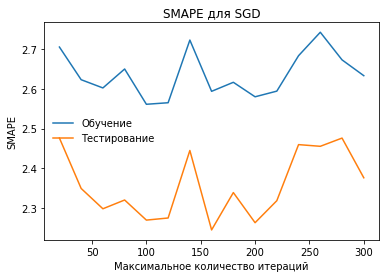

In [16]:
plt.title("SMAPE для SGD")
plt.xlabel("Максимальное количество итераций")
plt.ylabel("SMAPE")
plt.plot(max_iter_range, sgd_smape_train, label='Обучение')
plt.plot(max_iter_range, sgd_smape_test, label='Тестирование')
plt.legend(loc='center left', frameon=False)
plt.show()